In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
from tqdm import tqdm


import pyPSFstack
import pyPSFstack.pupils.sources as sources
import pyPSFstack.pupils.windows as windows
import pyPSFstack.pupils.aberrations as aberrations
from pyPSFstack.diversities.pupil_diversities import ZDiversity
import pyPSFstack.diversities.pola_diversities as pola_diversities

import torchPSFstack
import torchPSFstack.pupils.sources as torchsources
import torchPSFstack.pupils.windows as torchwindows
import torchPSFstack.pupils.aberrations as torchaberrations
from torchPSFstack.diversities.pupil_diversities import torchZDiversity
import torchPSFstack.diversities.pola_diversities as torchpola_diversities
from torchPSFstack.functions import get_pupils_param_dict, get_normNbck

# torchPSFstack: Retrieval from experimental data

# 1. Load data

We load the experimental data

In [2]:
with open(os.path.join('data','data_chido.dat'), 'rb') as input_file:
    exp_data = pickle.load(input_file)

This data contains the stacks for 10 beads ordered form the brightest to the dimmest, let us choose the brightest and covert the data into actual counts by removing the offset and multiplying by the appropriate factor. 

In [3]:
bead = 0
exp_stack = 0.24*(exp_data['psf_stacks'][bead]-100)
# number of diversities
N_z, N_p = exp_stack.shape[-2:]

Then we can plot the stack

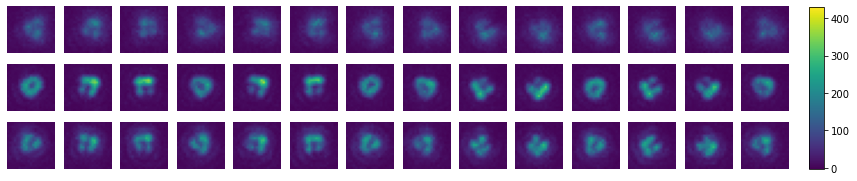

In [4]:
v_max = np.max(exp_stack)
v_min = np.min(exp_stack)

zdiv_mid_ind = N_z//2

fig, axs = plt.subplots(3,N_p,figsize=(N_p*1,3))
for ind in range(N_p):
    axs[0,ind].imshow(exp_stack[...,0,ind],vmin=v_min,vmax=v_max)
    im = axs[1,ind].imshow(exp_stack[...,zdiv_mid_ind,ind],vmin=v_min,vmax=v_max)
    axs[2,ind].imshow(exp_stack[...,-1,ind],vmin=v_min,vmax=v_max)
for ax in axs.ravel():
    ax.set_axis_off()

cb_ax = fig.add_axes([0.92,0.125,0.015,0.75])
fig.colorbar(im, cax=cb_ax)

# 2. Define experimental and computation parameters

In [5]:
# Define number of points use for the computation 
N_pts = 128

# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.515
cam_pixel_size = 6500
radius = 10
wavelength = 605
dipole_orientation = [0,0,0] # this means incoherent

# Define positions of defocus
z_step = exp_data['zstep']
z_list = np.arange(0,N_z*z_step,z_step)
z_list -= z_list[N_z//2]

# Define rotation angles for the polarization analyzer
angle_list = exp_data['qwp_angs']*np.pi/180
retardance =0.273 # this comes from Thorlabs for the wavelength used 

Put everything into dicts

In [6]:
params = {}

params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] = 0

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['gwp_angles'] = angle_list
params['pdiversity']['eta'] = 2*retardance*np.pi
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['aberrations'] = {}
params['aberrations']['jmax_list'] = 5*[14]

# 3. Retrieve the birefringent pupil

Instantiate all class elements needed for the model

In [14]:
# Define all the source, window and defocus pupils 
tsrc = torchsources.torchDipoleInterfaceSource(**params['pupil'], **params['source'])
tdef = torchwindows.torchDefocus(**params['pupil'],**params['defocus']) # This incorporate a defocus term to the optimization
twdw = torchaberrations.torchUnitaryZernike(**params['pupil'], **params['aberrations'])
tpupil_sequence = [tsrc, tdef, twdw]

# Define the diversities
tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
tpdiv = torchpola_diversities.torchPDiversity_Compound(
    [torchpola_diversities.torchPDiversity_GWP(params['pdiversity']['gwp_angles'],
                                               params['pdiversity']['eta']), 
     torchpola_diversities.torchPDiversity_LP([0, np.pi/2])])
     
# Put everything into an instance of torchPSFStack
model_retrieved = torchPSFstack.torchPSFStack(
                 exp_stack.shape[0],
                 tpupil_sequence,
                 zdiversity=tzdiv,
                 pdiversity=tpdiv,
                 tilts_flag=True # Need to use diversity dependent tilts
                 )

Determine overall scale factor, and background illumination. Include both background illumination and photobleaching amplitudes as optimization parameters.

In [15]:
data_norm, data_bck = get_normNbck(exp_stack)

# Then we compute a first estimate using the torch model with no gradient computation
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()

# Using this first estimate we can set the overall scale factor 
model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))

# We also initialize set the background illumination and tell the model
# to include it in the optimization parameters
model_retrieved.set_pb_bck(data_bck, opt_b=True, opt_a=True)

Set parameters for optimizer

In [16]:
lr = 3e-2 # learning rate
n_epochs = 200 # number of iterations

# Define cost function sccording to the noise statistics
loss_fn = torchPSFstack.cost_functions.loss_loglikelihood

# instatiate an optimzer from several readily available from torch
# here Adam is used
optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
# turn data into a torch tensor
data = torch.from_numpy(exp_stack).type(torch.float)

Run optimization

100%|██████████| 200/200 [02:54<00:00,  1.14it/s]


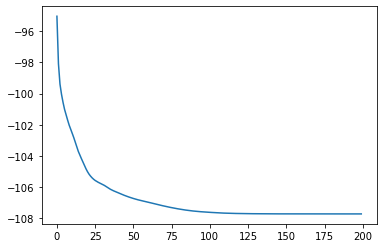

In [17]:
loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    stack_modeled = model_retrieved()
    
    loss = loss_fn(stack_modeled, data)
    loss_evol += [loss.item()] # add loss to list 
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

plt.plot(loss_evol)

# 4. Analyze results

In [18]:
def plot_stack(stack):
    N_z, N_p = stack.shape[-2:]
    v_max = np.max(stack)
    v_min = np.min(stack)

    zdiv_mid_ind = N_z//2

    fig, axs = plt.subplots(3,N_p,figsize=(N_p*1,3))
    for ind in range(N_p):
        axs[0,ind].imshow(stack[...,0,ind],vmin=v_min,vmax=v_max)
        im = axs[1,ind].imshow(stack[...,zdiv_mid_ind,ind],vmin=v_min,vmax=v_max)
        axs[2,ind].imshow(stack[...,-1,ind],vmin=v_min,vmax=v_max)
    for ax in axs.ravel():
        ax.set_axis_off()

    cb_ax = fig.add_axes([0.92,0.125,0.015,0.75])
    fig.colorbar(im, cax=cb_ax)

Compare the experimental and retrieved PSF stacks

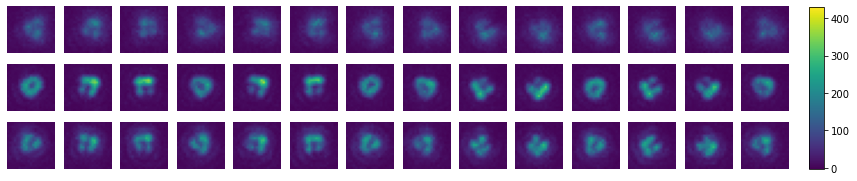

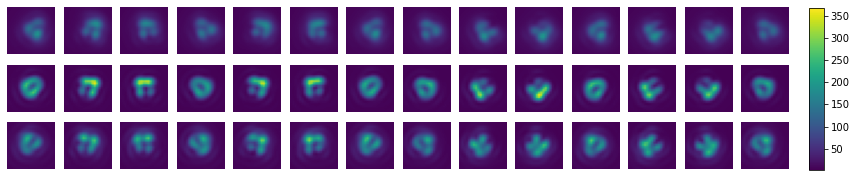

In [20]:
plot_stack(exp_stack)
plot_stack(stack_modeled.detach().numpy())

Then we can retrieve the parameters and define an aberration pupil using pyPSFstack.

In [21]:
ret_pupil_params = get_pupils_param_dict(model_retrieved)
ret_pupil_params.keys()

dict_keys(['pupil0', 'pupil1', 'pupil2', 'tilts', 'pb_bck'])

Then plot the pupil where we clearly see the SEO used experimentally.

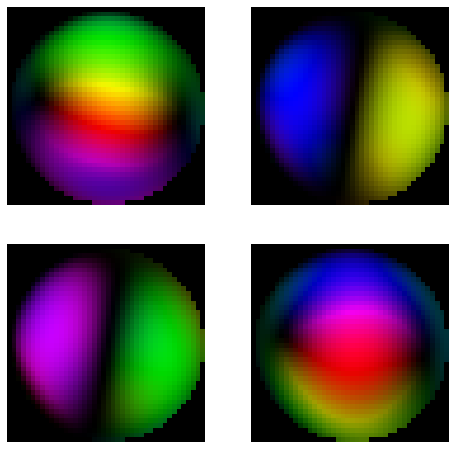

In [23]:
ret_pupil_params['pupil2']['c_W'][0:2]=0 # can remove overall tilt factors
abe = aberrations.UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
abe.plot_pupil_field()